In [36]:
import keras

In [2]:
%pylab inline
import os
import pickle
from scipy.misc import imresize

Populating the interactive namespace from numpy and matplotlib


In [40]:
sess = K.tf.Session()

In [42]:
K.set_session(sess)

In [43]:
model = keras.models.load_model('model_data/yolo2.h5')

In [4]:
import colorsys
import imghdr
from yad2k.models.keras_yolo import yolo_eval, yolo_head
from keras import backend as K
import numpy as np
import cv2

In [5]:
pylab.rcParams['figure.figsize'] = (14, 12)

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def reduce(img):
    return np.reshape(img, img.shape[:2])

def plot_images(images, row=1, im_prep=None, titles=None, cmap=None, figsize=(12, 12)):
    add_col = 1 if (len(images) % row) else 0
    col = (len(images) // row) + add_col
    fig, axes = subplots(row,col, subplot_kw={'xticks': [], 'yticks': []}, figsize=figsize)
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    if im_prep is None:
        im_prep = lambda x: x

    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        img = im_prep(images[i])
        if (len(img.shape) < 3) and cmap is None:
            cmap='gray'
        ax.imshow(img, cmap=cmap)
        if titles is not None:
            ax.set_title(titles[i])
    show()
    
def get_points(img, simg, pt1, pt2):
    """
    finds the scale of simg agains img
    returns (pt1, pt2) * scale
    """
    ky = img.shape[0]/simg.shape[0]
    kx = img.shape[1]/simg.shape[1]
    k = np.array([kx, ky])
    rt1 = (np.array(pt1)*k).astype(np.uint).tolist()
    rt2 = (np.array(pt2)*k).astype(np.uint).tolist()
    return (tuple(rt1), tuple(rt2))

In [44]:
anchors_path = 'model_data/yolo_anchors.txt'
classes_path = 'model_data/coco_classes.txt'

with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

yolo_model = model

# Verify model, anchors, and classes are compatible
num_classes = len(class_names)
num_anchors = len(anchors)

model_output_channels = yolo_model.layers[-1].output_shape[-1]

# Check if model is fully convolutional, assuming channel last order.
model_image_size = yolo_model.layers[0].input_shape[1:3]

# Generate output tensor targets for filtered bounding boxes.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=0.4,
    iou_threshold=0.4)

In [45]:
sess = K.get_session() 

In [122]:
font = cv2.FONT_HERSHEY_COMPLEX
def process(img, incl_box=False):
    #img = img.copy()
    image = cv2.resize(bgr2rgb(img), model_image_size)
    image_data =  image.astype(np.float32)

    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    #img = image
    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.shape[1], image.shape[0]],
            K.learning_phase(): 0
        })
    #print('Found {} boxes '.format(len(out_boxes)))
    ret_box = []
    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.shape[0], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.shape[1], np.floor(right + 0.5).astype('int32'))
        pt1 = (left, top)
        pt2 = (right, bottom)
        pt1, pt2 = get_points(img, image, pt1, pt2)
        #cv2.rectangle(img, pt1, pt2, [0, 255, 0], 2)        
        ret_box.append((pt1, pt2))
        #textSize,_ = cv2.getTextSize(label, font, 1, 2)
        #cv2.putText(img, label, (pt1[0], pt1[1]-textSize[1]), font, 1, (255, 0, 0), 2)
    if incl_box:
        return (img, ret_box)
    return img

In [47]:
img = imread('./test_images/test6.jpg')

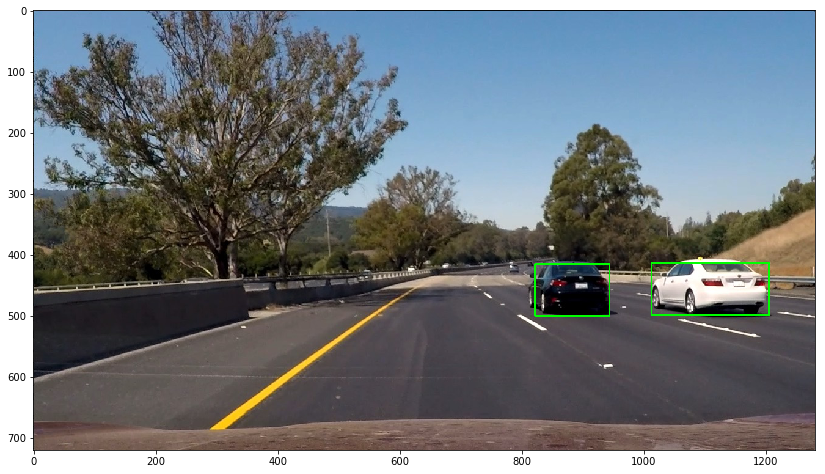

In [62]:
imshow(process(img.copy()))

In [32]:
sess.close()

In [114]:
cap = cv2.VideoCapture('../Advanced-Lane-Lines/project_video.mp4')

In [67]:
# imgs = []
for i in range(100,200):
    ret, frame = cap.read()
    cv2.imwrite('output/frame{:02d}.jpg'.format(i), frame)
    imgs.append(frame)

In [51]:
cv2.namedWindow("preview3")
cap = cv2.VideoCapture('../Advanced-Lane-Lines/project_video.mp4')
ret = True
i = 0
while ret:
    #try:
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            retimg = process(frame)
            retimg = cv2.cvtColor(retimg, cv2.COLOR_RGB2BGR)
            cv2.imshow("preview3", retimg)
        key = cv2.waitKey(1) & 0xFF
        if key == ord(' '):
            break
        i += 1
#     except Exception as e:
#         throw
#         print(e)
#         break
cap.release()
cv2.destroyAllWindows()

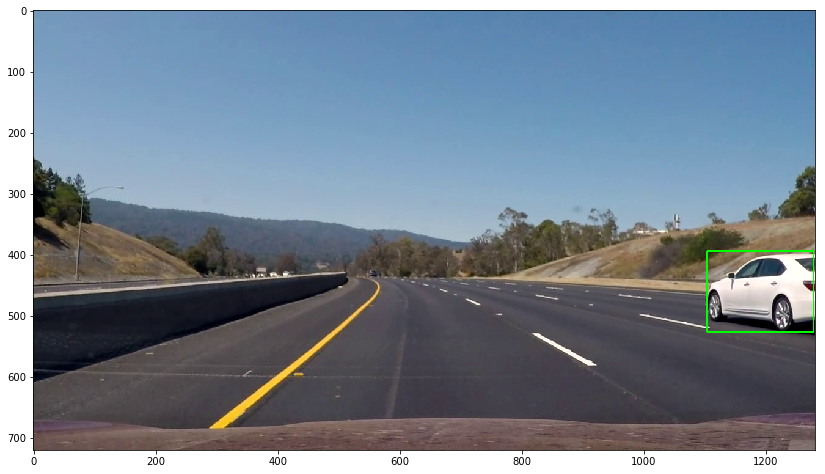

In [74]:
imshow(bgr2rgb(process(imgs[1])))

In [75]:
img, b = process(imgs[1], True)

In [81]:
b[0]

((1105, 396), (1280, 519))

In [82]:
bs = []
limg = imgs[-1].copy()
for img in imgs:
    _,b = process(img, True)
    pt1, pt2 = b[0]
    cv2.rectangle(limg, pt1, pt2, [0, 255, 0], 2) 
    bs.append(b)

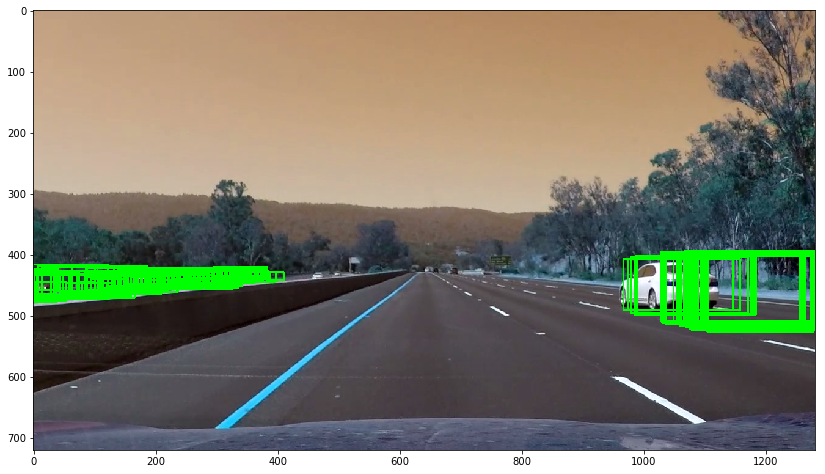

In [88]:
imshow(limg)

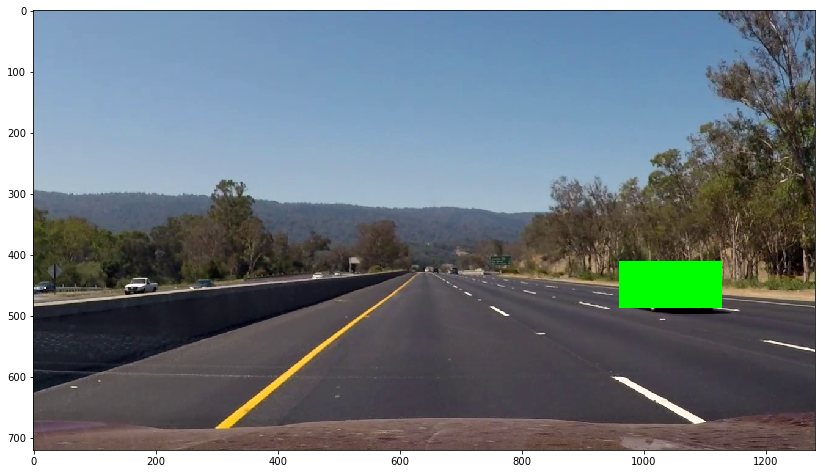

In [87]:
ltimg = imgs[-1].copy()
b = bs[-1]
pt1, pt2 = b[2]
cv2.rectangle(ltimg, pt1, pt2, [0, 255, 0], -1) 
imshow(bgr2rgb(ltimg))

In [89]:
heatmap = np.zeros(shape=ltimg.shape[:2])
for b in bs:
    for pts in b:
        pt1,pt2 = pts
        heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1

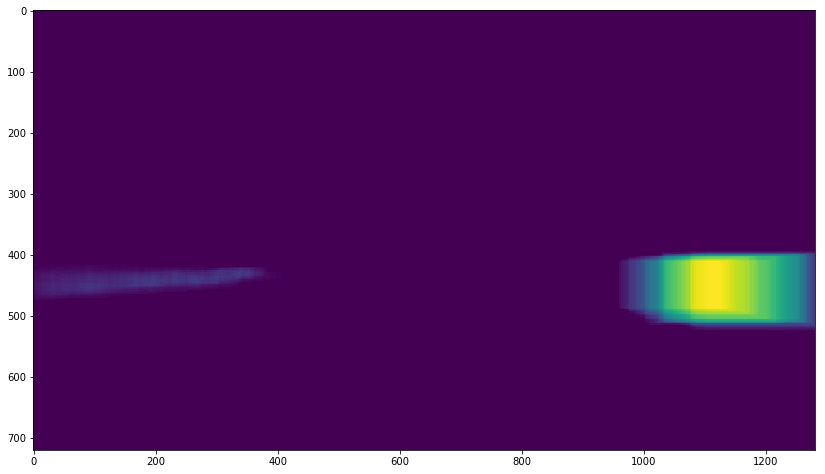

In [92]:
heatmap[heatmap<2]=0
imshow(heatmap)

In [94]:
from scipy.ndimage.measurements import label

In [95]:
labels = label(heatmap)

2 cars found


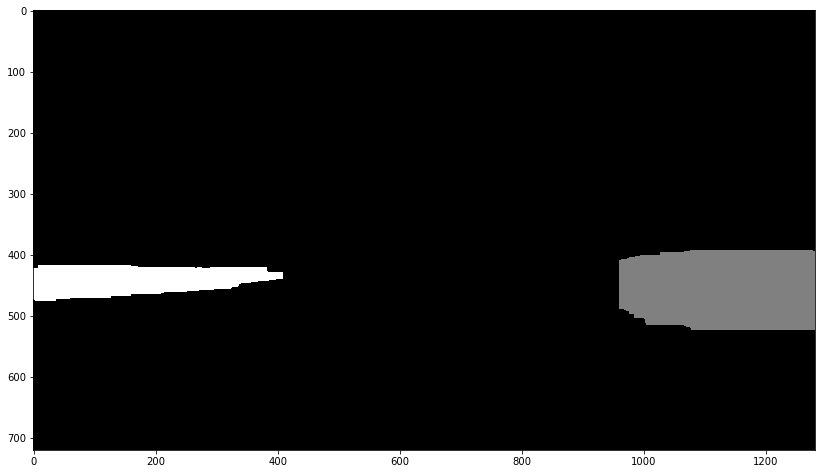

In [100]:
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

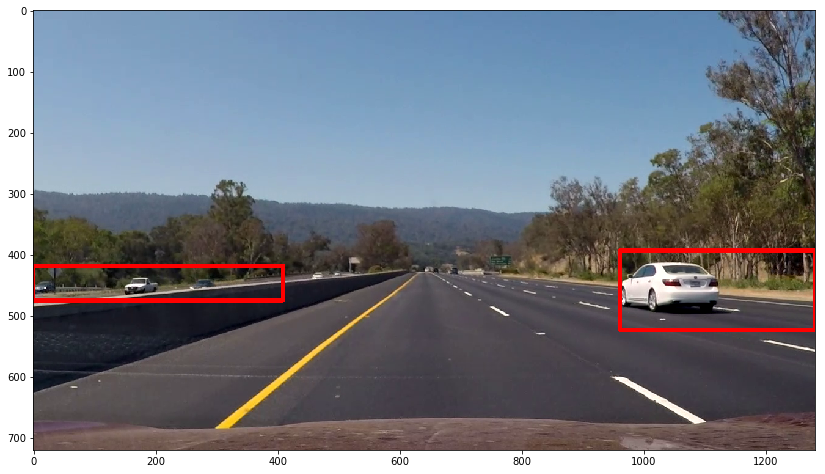

In [101]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
bimg = draw_labeled_bboxes(imgs[-1].copy(), labels)
imshow(bgr2rgb(bimg))

In [102]:
from collections import deque

In [131]:
def overlay_image(img, s_img, pos, size=None):
    x_offset,y_offset=pos
    l_img = img.copy()
    if size is not None:
        s_img = imresize(s_img, size)
    if len(s_img.shape) == 2:
        s_img = cv2.merge((s_img,s_img,s_img))
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
    return l_img

In [134]:
def overlap(r1,r2):
    hoverlaps = (r1[0][0] <= r2[1][0].right) and (r1[1][0] >= r2[0][0])
    voverlaps = (r1[0][1] >= r2[1][1]) and (r1[1][1] <= r2[0][1])
    return hoverlaps and voverlaps

In [137]:
qb = deque(maxlen=3)
def pipeline(image):
    _, bn = process(image, True)
    heatmapn = np.zeros(shape=image.shape[:2])    
    heatmap = np.zeros(shape=image.shape[:2])
    
    for pts in bn:
        pt1,pt2 = pts
        heatmapn[pt1[1]:pt2[1],pt1[0]:pt2[0]] = 1
    qb.append(bn)
            
    for b in qb:
        for pts in b:
            pt1,pt2 = pts
            heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1
    
    heatmap[heatmapn==0]=0
#     qb.append(bn)
    
    heatmap[heatmap<2] = 0
    labels = label(heatmap)
    bimg = draw_labeled_bboxes(image.copy(), labels)
    bimg = overlay_image(bimg, heatmap, (0,0), (200,400))
    return bimg

In [140]:
cv2.namedWindow("preview3")
cap = cv2.VideoCapture('../Advanced-Lane-Lines/project_video.mp4')
ret = True
i = 0
while ret:
    #try:
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            retimg = pipeline(frame)
            retimg = cv2.cvtColor(retimg, cv2.COLOR_RGB2BGR)
            cv2.imshow("preview3", retimg)
        key = cv2.waitKey(1) & 0xFF
        if key == ord(' '):
            break
        i += 1
#     except Exception as e:
#         throw
#         print(e)
#         break
cap.release()
cv2.destroyAllWindows()